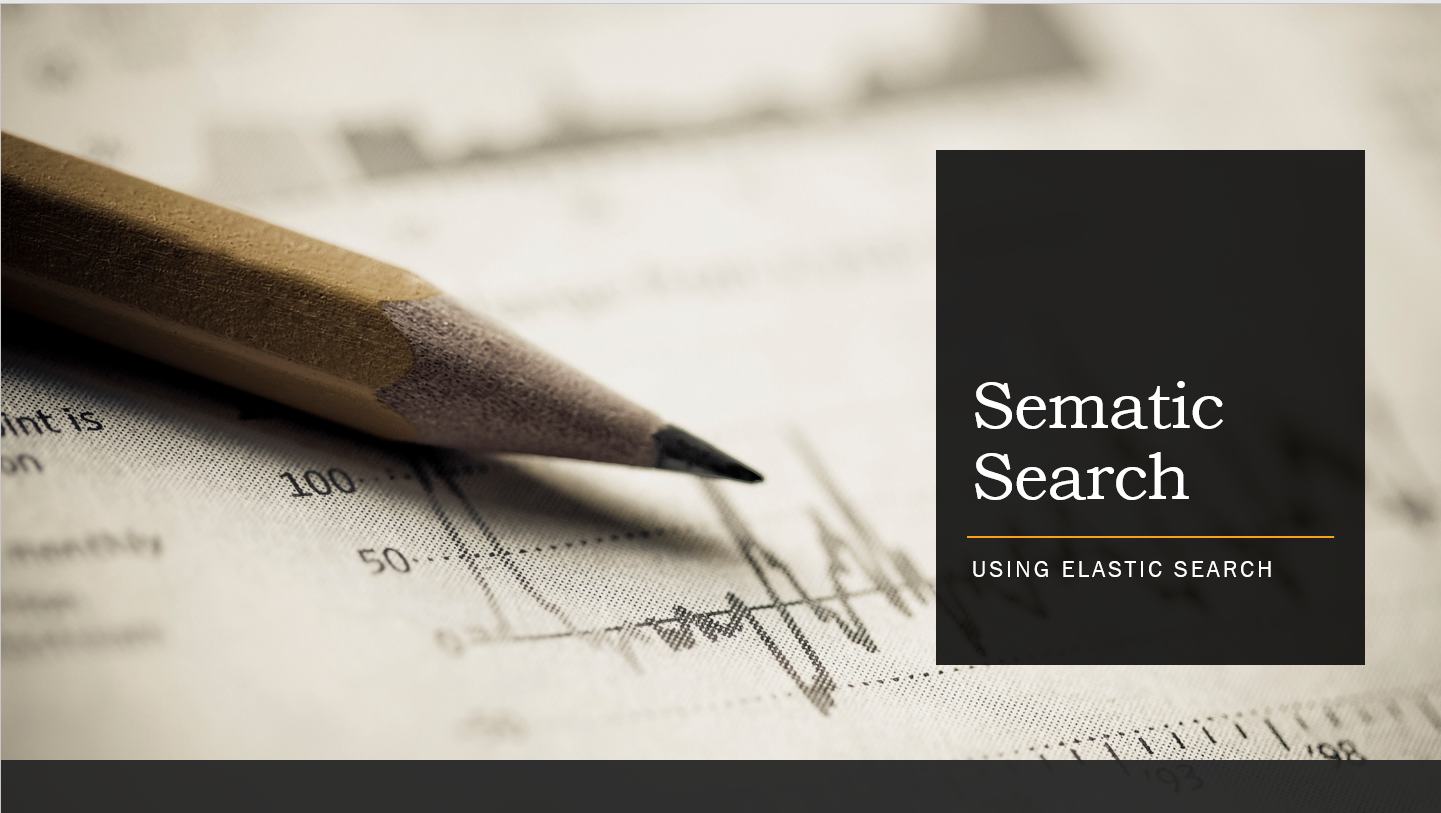

### References
- https://www.jpmorgan.com/technology/technology-blog/faq-bot
- https://www.elastic.co/guide/en/elasticsearch/reference/current/run-elasticsearch-locally.html

### Prerequisites

- Python & Jupyter Notebook
- Elastic Search Server
- Sentence Transformers & Elastic Search Python Libraries
- Basic knowledge of Python programming language
- Basic knowledge of Semantic Search
- Basic Knowledge of LLMs & Sentence Embeddings

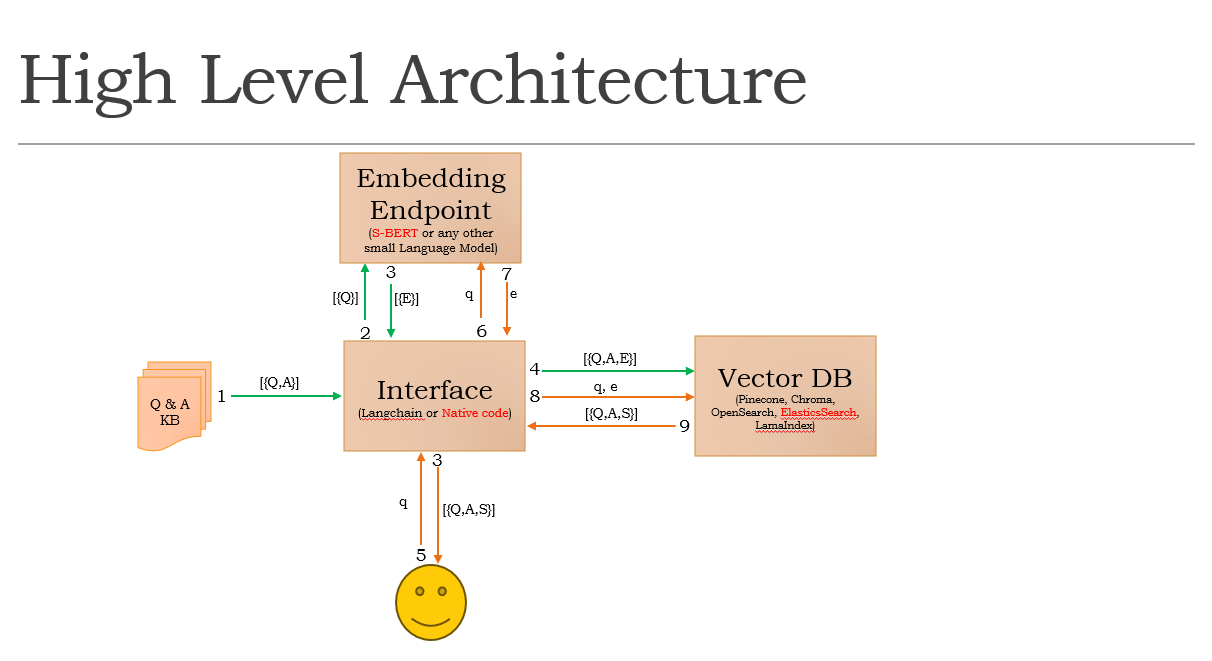

In [1]:
#!pip install sentence_transformers
#!pip install elasticsearch

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sentence_transformers import SentenceTransformer
sentence_transformer = SentenceTransformer("bert-base-nli-mean-tokens")

In [4]:
question="what is your name?"
embedding_test = sentence_transformer.encode(question)

In [5]:
embedding_test

array([ 4.15454775e-01, -9.41586215e-03,  1.36566842e+00, -1.01299725e-01,
        7.61589885e-01,  1.07603896e+00, -1.51860401e-01,  5.45779288e-01,
       -2.41459146e-01,  6.96089685e-01, -3.92739236e-01,  3.18117626e-02,
        2.63910979e-01,  7.05804229e-01, -2.49983668e-01,  4.41484243e-01,
       -3.14223111e-01,  8.60440210e-02,  3.06357890e-01, -2.40721911e-01,
       -4.41181183e-01,  9.99783397e-01, -3.63469236e-02, -5.46104789e-01,
        9.84007716e-02,  2.48338744e-01,  2.15461880e-01, -1.55092132e+00,
       -9.30506289e-01, -2.79167235e-01, -7.35220984e-02, -4.32736933e-01,
        1.10970192e-01,  1.27837315e-01, -1.34739295e-01,  4.75960486e-02,
       -6.88596725e-01,  3.93133834e-02, -1.69098020e-01, -5.13606012e-01,
        9.86724645e-02, -2.96295196e-01,  3.60007495e-01,  6.99401438e-01,
       -5.12411296e-01, -7.37685621e-01,  2.31668563e-03,  1.75797239e-01,
       -7.23935902e-01, -8.30275536e-01, -8.96229446e-01, -8.46172810e-01,
        4.78065163e-01,  

In [6]:
embedding_test.tolist()

[0.41545477509498596,
 -0.009415862150490284,
 1.3656684160232544,
 -0.1012997254729271,
 0.7615898847579956,
 1.0760389566421509,
 -0.15186040103435516,
 0.545779287815094,
 -0.24145914614200592,
 0.6960896849632263,
 -0.3927392363548279,
 0.03181176260113716,
 0.2639109790325165,
 0.7058042287826538,
 -0.24998366832733154,
 0.4414842426776886,
 -0.31422311067581177,
 0.08604402095079422,
 0.30635789036750793,
 -0.2407219111919403,
 -0.4411811828613281,
 0.9997833967208862,
 -0.0363469235599041,
 -0.5461047887802124,
 0.0984007716178894,
 0.2483387440443039,
 0.2154618799686432,
 -1.5509213209152222,
 -0.9305062890052795,
 -0.2791672348976135,
 -0.07352209836244583,
 -0.43273693323135376,
 0.11097019165754318,
 0.12783731520175934,
 -0.13473929464817047,
 0.047596048563718796,
 -0.6885967254638672,
 0.039313383400440216,
 -0.16909801959991455,
 -0.5136060118675232,
 0.09867246448993683,
 -0.2962951958179474,
 0.36000749468803406,
 0.6994014382362366,
 -0.5124112963676453,
 -0.73768562

In [7]:
len(embedding_test)

768

In [8]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch(hosts="https://localhost:9200", basic_auth=('elastic', '8CciM2atqVjM5bJD-T*d'), ca_certs='config/certs/http_ca.crt', verify_certs=False)

INDEX_NAME = "faq_bot_index"
EMBEDDING_DIMS = 768

def create_index() -> None:
    es_client.indices.delete(index=INDEX_NAME, ignore=404)
    es_client.indices.create(
        index=INDEX_NAME,
        ignore=400,
        body={
            "mappings": {
                "properties": {
                    "embedding": {
                        "type": "dense_vector",
                        "dims": EMBEDDING_DIMS,
                    },
                    "question": {
                        "type": "text",
                    },
                    "answer": {
                        "type": "text",
                    }
                }
            }
        }
    )

create_index()

In [9]:
from typing import List, Dict
def index_qa_pairs(qa_pairs: List[Dict[str, str]]) -> None:
    for qa_pair in qa_pairs:
        question = qa_pair["question"]
        answer = qa_pair["answer"]
        embedding = sentence_transformer.encode(question).tolist()
        #print(embedding)
        data = {
            "question": question,
            "embedding": embedding,
            "answer": answer,
        }
        #print(data)        
        es_client.index(index=INDEX_NAME, body=data)

qa_pairs = [{"question": "How do I improve my English speaking? ", "answer": "Speak more",},
            {"question": "What should I do to earn money online? ", "answer": "Learn machine learning",},
            {"question": "How can I improve my skills? ", "answer": "More practice",}]

index_qa_pairs(qa_pairs)

In [10]:
ENCODER_BOOST = 10

def query_question(user_question: str, top_n: int=10) -> List[dict]:
    embedding = sentence_transformer.encode(user_question).tolist()
    es_result = es_client.search(
        index=INDEX_NAME,
        body={
            "from": 0,
            "size": top_n,
            "_source": ["question", "answer"],
            "query": {
                "script_score": {
                    "query": {
                        "match": {
                            "question": user_question
                        }
                    },
                    "script": {
                        "source": """
                            (cosineSimilarity(params.query_vector, "embedding") + 1)
                            * params.encoder_boost + _score
                        """,
                        "params": {
                            "query_vector": embedding,
                            "encoder_boost": ENCODER_BOOST,
                        },
                    },
                }
            }
        }
    )
    hits = es_result["hits"]["hits"]
    clean_result = []
    print(hits)
    for item in hits:
        clean_result.append({
            "question": item["_source"]["question"],
            "answer": item["_source"]["answer"],
            "score": item["_score"],
        })
    return clean_result

In [15]:
query_question("How to earn?")

[{'_index': 'faq_bot_index', '_id': 'J39MMIwBzpCfCZ5jlaRl', '_score': 17.986187, '_source': {'question': 'What should I do to earn money online? ', 'answer': 'Learn machine learning'}}, {'_index': 'faq_bot_index', '_id': 'KH9MMIwBzpCfCZ5jlaTp', '_score': 16.769941, '_source': {'question': 'How can I improve my skills? ', 'answer': 'More practice'}}, {'_index': 'faq_bot_index', '_id': 'Jn9MMIwBzpCfCZ5jlKTt', '_score': 14.164326, '_source': {'question': 'How do I improve my English speaking? ', 'answer': 'Speak more'}}]


[{'question': 'What should I do to earn money online? ',
  'answer': 'Learn machine learning',
  'score': 17.986187},
 {'question': 'How can I improve my skills? ',
  'answer': 'More practice',
  'score': 16.769941},
 {'question': 'How do I improve my English speaking? ',
  'answer': 'Speak more',
  'score': 14.164326}]

# Recap - Current Architecture

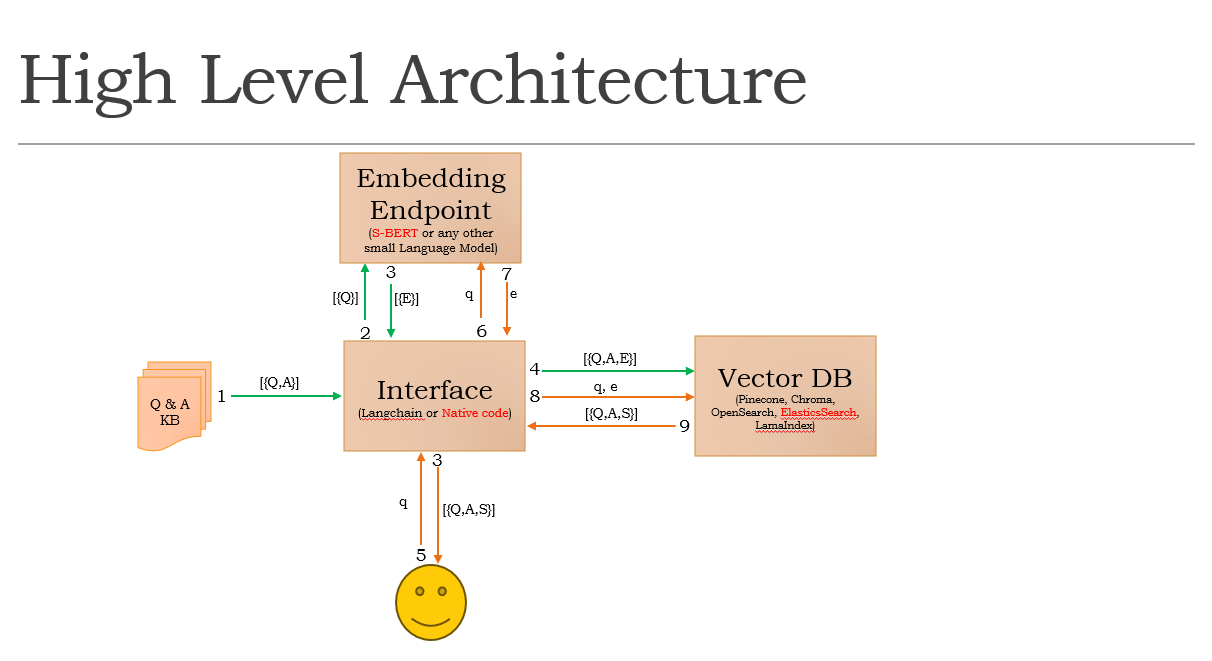

# Future Enhancement - RAG

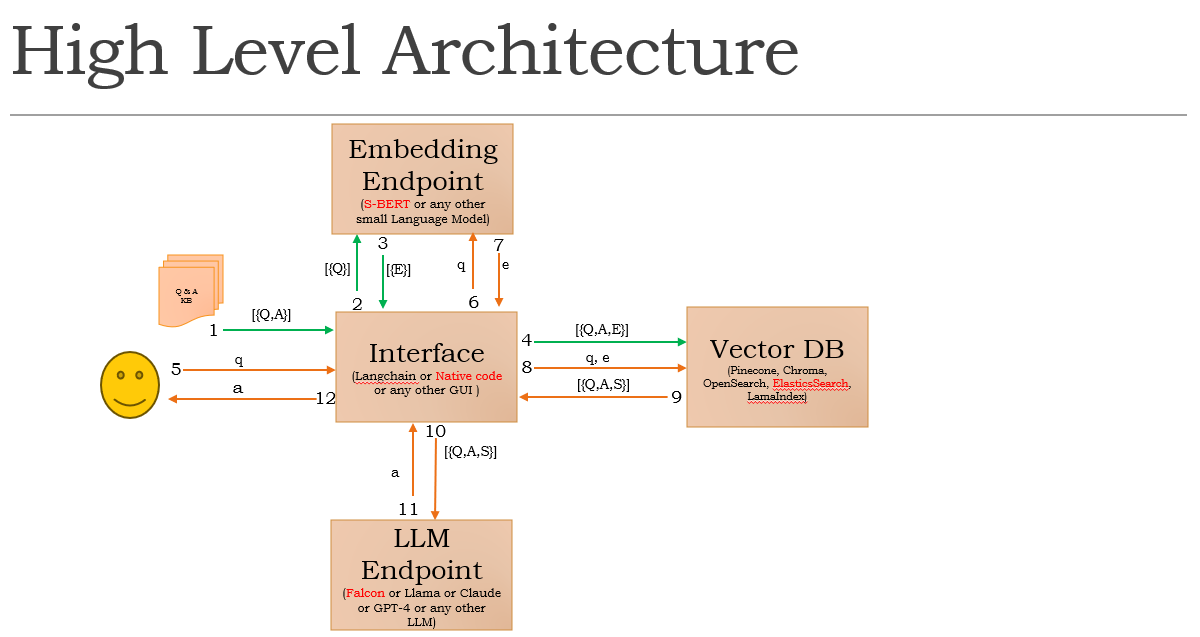